In [26]:
# IPython notebook to calculate LW TOA radiative responses using radiative kernels
# for individual months in Aqua4xCO2 case.
#
# These will have Gregory regressions run on them in "GregoryIndividualFeedbacks.ipynb"
# (or a subsequent version of that notebook)
#
# Rick Russotto
# Started 2019-07-25

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#Climatological data for baseline for kernels
#Actually need to load non-regridded versions (from MakeNetCDF_noregrid.py) for hus and ta.
ds_clim_2D = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl') #For surface temperature
#ds_clim_3D = xr.open_dataset('../nc_revised_20181130/master_plev.nc').sel(exp='AquaControl') #For specific humidity
ds_clim_for_plevs = xr.open_dataset('../nc_ta/master_ta.nc').sel(exp='AquaControl') #For atmospheric temperature
#Actually above is not used--instead original grid climatological temperature data in each model. 
#But need the above to calculate pressure level widths. 

In [5]:
#Names of models in CMORized climate model output files
model_filenames = {'AM2': 'AM21', 
                   'CAM3': 'CAM3', 
                   'CAM4': 'CAM4',
                   'CNRM-AM6-DIA-v2': 'CNRM-AM5', 
                   'ECHAM-6.1': 'ECHAM61', 
                   'ECHAM-6.3': 'ECHAM63', 
                   'GISS-ModelE2': 'GISS-ModelE2',
                   'IPSL-CM5A': 'LMDZ5A', 
                   'MIROC5': 'MIROC5', 
                   'MPAS': 'MPAS', 
                   'MetUM-GA6-CTL': 'MetUM-CTL', 
                   'MetUM-GA6-ENT': 'MetUM-ENT', 
                   'NorESM2': 'CAM5Nor'}

In [6]:
#Models for which I was able to run radiative kernels: everything except Caltech and GISS
#(maybe could do GISS? but doesn't seem worth it)

models_12 = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL',
             'MetUM-GA6-ENT', 'NorESM2']

In [7]:
#Calculate pressure level differences/layer thicknesses
print(ds_clim_for_plevs.plev)
#array([  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,
#        30000,  40000,  50000,  60000,  70000,  85000,  92500, 100000])

#what are the midpoints? 
plev = ds_clim_for_plevs.plev.data
plev_mp = (plev[1:]+plev[:-1])/2
print(plev_mp)
#[ 1500.  2500.  4000.  6000.  8500. 12500. 17500. 22500. 27500. 35000.
# 45000. 55000. 65000. 77500. 88750. 96250.]

#Add TOA boundary
plev_mp0 = np.insert(plev_mp,0,0)
print(plev_mp0)
#[    0.  1500.  2500.  4000.  6000.  8500. 12500. 17500. 22500. 27500.
# 35000. 45000. 55000. 65000. 77500. 88750. 96250.]

#Drop last layer and extend 2nd-to-last all the way to ground (101325) 
plev_mp0[-1] = 101325
print(plev_mp0)
#[     0.   1500.   2500.   4000.   6000.   8500.  12500.  17500.  22500.
#  27500.  35000.  45000.  55000.  65000.  77500.  88750. 101325.]

#Take differences
plev_widths = np.diff(plev_mp0)
print(plev_widths)
#[ 1500.  1000.  1500.  2000.  2500.  4000.  5000.  5000.  5000.  7500.
# 10000. 10000. 10000. 12500. 11250. 12575.]

#OK, there are now 16 thicknesses (in Pa) to multiply the kernel results
#(in w/m^2/K/Pa, for temperature) by. Make sure to use Pa units and 
#ignore bottom layer.

<xarray.DataArray 'plev' (plev: 17)>
array([  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,
        30000,  40000,  50000,  60000,  70000,  85000,  92500, 100000])
Coordinates:
    exp      <U11 'AquaControl'
  * plev     (plev) int64 1000 2000 3000 5000 7000 ... 70000 85000 92500 100000
[ 1500.  2500.  4000.  6000.  8500. 12500. 17500. 22500. 27500. 35000.
 45000. 55000. 65000. 77500. 88750. 96250.]
[    0.  1500.  2500.  4000.  6000.  8500. 12500. 17500. 22500. 27500.
 35000. 45000. 55000. 65000. 77500. 88750. 96250.]
[     0.   1500.   2500.   4000.   6000.   8500.  12500.  17500.  22500.
  27500.  35000.  45000.  55000.  65000.  77500.  88750. 101325.]
[ 1500.  1000.  1500.  2000.  2500.  4000.  5000.  5000.  5000.  7500.
 10000. 10000. 10000. 12500. 11250. 12575.]


In [ ]:
#Need to load these files and "repackage" into the variables that I need for the radiative kernels,
#like I did for APRP. 

#Which variables are necessary? (see "ApplyKernels.ipynb")

#Surface tempertaure kernel: "ts" (2D)
#Atmospheric temperature kernel: "ta" (3D)
#Water vapor kernel: "hus" (3D) and "ta" (3D)

#In the climatology these are in 3 different NetCDF files.
#In the monthly output, could put "ta" and "hus" in same XArray Dataset but "ts" should probably be separate.

#Regridding: 

#Have already regridded the kernels to the climatology lats/lons in "../aquakernels_Feldl/aquakernels/Kernel_Explore.ipynb"

#So also want to regrid the monthly output to the same lat/lons.

#For APRP I first compiled the necessary output in a NetCDF file (separate for each model)
#then regridded in a separate script. 

#Actually, surface temperature was included in those files ("monthlyForGregAPRP_a4_rg_[model].nc")
#so don't need to load or regrid that one for the surface temperature kernel.

#Just regrid the "ta" and "hus" data to the 1D lat/lon grid. 
#Use same methodology I used to regrid the kernels--how did I do this?

#Or... could go back and regrid the kernels to the same grid as each of the models. 
#That would save space.
#Then after vertically integrating, regrid the results to the climatology grid.


#Actually, never even downloaded the 3D temperature and humidity output. Need to go get this from ESGF...

#Set up wget script to download those. It's going to take hours... but can write code in the meantime. 

In [ ]:
# #Check for extra vertical levels. 
# #Yes, all have 17
# #for model in models_12:
# ds_temp=dict()
# for model in models_12:
#     print(model)
#     var = 'ta'
#     ds_temp[var] = xr.open_dataset(glob.glob('../nc_esgf/Amon/'+var+'_Amon_'+
#             model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
#     print(ds_temp[var].plev)

In [ ]:
#Loop through the models, save the two variables to a new NetCDF file containing both
#Wait--definitely want to regrid first, because this will create too much data.
#Even this regridding will more than double the amount of data stored...
#Maybe do it temporarily while running the kernels? But then will probably take forever 
#to run and have to redo regridding if something goes wrong.
#But then what about "sanity check" plots that the regridding worked?
#Will have the final sanity check about whether Gregory regression "adds up" 
#to the previously diagnosed radiative responses. Can also still do a couple of test plots.

#After changing plans (regrid the kernels to individual model grids):
#Just apply the kernels in one loop, then vertically integrate,
#THEN regrid and save to a NetCDF file.
#Can also do the surface temperature kernel in the same loop, so NetCDF file
#will have the results from 3 kernels in it. 

#Actually, simpler to just do temperature and humidity separately, because
#humidity is more complicated (standard anomaly, etc.)

# vars_3d_kernels = ['ta', 'hus']

# for model in models_12:
#     print('Loading monthly mean temperature and humidity for kernels: ' + model)
#     ds_temp = dict()
#     for var in vars_3d_kernels:
#         ds_temp[var] = xr.open_dataset(glob.glob('../nc_esgf/Amon/'+var+'_Amon_'+
#             model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    
    
    
    
    
        


In [ ]:
#Apply the temperature kernels in a loop over models and months;
#Vertically integrate, then regrid to the common climatology grid.

dLW_ta_dict = dict()
for model in models_12:
#for model in ['NorESM2']:
#for model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
    print('Kernel multiplication (atmospheric temperature) for model: ' + model)
    ds_clim_ta = xr.open_dataset('../nc_plev_non_regridded/master_plev_og_'+model+'.nc').sel(exp='AquaControl')
    kernel_ta = xr.open_dataset('../aquakernels_Feldl/aquakernels/regridded_model_grids/lw_t_rg_'+model+'.nc')
    ds_mon_ta = xr.open_dataset(glob.glob('../nc_esgf/Amon/ta_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_ta = ds_mon_ta.reindex(plev=ds_mon_ta.plev[::-1]) #Flip pressure levels to match the order for the other two
    numMonths = len(ds_mon_ta.time)
    
    #Preallocate something to store the output after multiplication and vertical integration for each month
    #Maybe save NetCDF file here and regrid later? Well, that will create more data
    dLW_ta_raw = np.zeros([numMonths, len(ds_mon_ta.lat), len(ds_mon_ta.lon)]) 
    
    #Loop through the months
    for i in np.arange(numMonths):
    #for i in np.arange(3): #debug
        if i % 20 == 0:
            print('month '+str(i))
        ds_clim_i = ds_clim_ta.isel(time=i%12)['ta']
        ds_mon_ta_i = ds_mon_ta.isel(time=i)['ta']
        #attempt to do subtraction with a regular NumPy array and a DataArray
        ds_mon_ta_i_raw = ds_mon_ta_i.data
        #print(ds_clim_i)
        #print(ds_mon_ta_i)
        #print(kernel_ta)
        
        #Interpolate from grid box boundaries to centers for the MetUM models
        #Use a temporary raw array, then reassign coords at the end
        if model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
            temp_raw = ds_clim_i.data
            #print(np.shape(temp_raw)) #dimensions 17, 145, 192 (plev, lat, lon)
            #print(np.shape(temp_raw[:,:,0])) #17,145 
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            #print(np.shape(temp_raw_1)) #17,145,193
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            #print(np.shape(temp_raw_3)) #17,144,192
            
            #Reconstruct the XArray object. 
            #Dimensions of this variable don't actually matter from this point, except for dropping bottom plev
            ds_clim_i = xr.DataArray(temp_raw_3, {'plev': ds_mon_ta_i.plev, 'lat': ds_mon_ta_i.lat, 'lon': ds_mon_ta_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
        
        dT_i = ds_mon_ta_i_raw - ds_clim_i
        #Get error at this point: seems like the pressure levels are reversed, also -180 to 180 vs 0 to 360 latitudes.
        #Should also check pressure levels order in the original ApplyKernels code.
        
        #print(dT_i)
        #print(kernel_ta)
        #print(ds_clim_i)
        #print(ds_mon_ta_i)
        #print(ds_mon_ta_i_raw)
        #print(dT_i)
        
    
        #Kernel also has different precision of lat and 360 vs 180 lon. Try this:
        
        #Drop bottom layer when multiplying kernel by temperature differece 
        #(since some models are missing data in the bottom layer sometimes)
        kernel_i = kernel_ta.isel(plev=np.arange(len(plev_widths)), time=i%12)
        #print(kernel_i.isel(plev=3))
        kernel_raw = kernel_i['__xarray_dataarray_variable__'].data
        #print(kernel_raw)
        
        #plt.figure()
        
        
        #taTimesKernel_i = dT_i.isel(plev=np.arange(len(plev_widths)))*kernel_ta.isel(plev=np.arange(len(plev_widths)))
        taTimesKernel_i = dT_i.isel(plev=np.arange(len(plev_widths)))*kernel_raw
        
        #print(taTimesKernel_i) #plev, lat, lon
        
        #8/1/19, 10:04 PM: works up to this point
        
        #1/24/20: I think here is the break-off point; before vertically integrating, either subtract the vertical mean change
        # or the deviation from it. 
        # Or is it done before even multiplying by the kernel? The vertically uniform vs. varying component of the temperature change.
        
        #Vertically integrate (divide by 10000 because kernel was in W/m^2/100 hPa)
        dLW_ta_raw[i,:,:] = (taTimesKernel_i*plev_widths[:, None, None]/10000.0).sum(dim='plev')
        
    #Create XArray DataArray with the result
    dLW_ta_dict[model] = xr.DataArray(dLW_ta_raw, {'time': ds_mon_ta.time, 'lat': ds_mon_ta.lat, 'lon': ds_mon_ta.lon},  
                                      dims=['time', 'lat', 'lon'], name='dLW')
    
    #Regrid results to common climatology grid?
    #Or leave in dict of XArray DataArrays for now (saving intermediate result), regrid in a loop 
    #and then save to NetCDF
    
    #Problem: the *climatological* temperatures, necessary to calculate how much temperatures have changed, are already on the 
    #1-degree grid. So the kernel being on the model grid is useless right now. 
    
    #Options: 
    #1. Use the climatological temperatures from before regridding (where I obtained the data from in the script)
    #   then regrid later.
    #2. Go back and regrid the monthly temperature and humidity output to the 1-degree grid like I was originally going to
    
    #Keep in mind I will also have to apply the same methods for the humidity kernel. 
    #Option 2 creates far more data but might be more reliable. 
    #Could also do the regridding inside this loop, not saving any intermediate result from that. But that might 
    #be too slow especially if I end up having to run this loop more than once. 
    #How much storage on Fletcher is reasonable? Ask Naomi?
    
    #For option 1 see "MakeNetCDF_ta" script, could run version without doing horizontal regridding or merging the different
    #models into one NetCDF file. Would also have to do this for hus.
    
    #Went with option 1 (obtained the non-regridded temperatures). 
    #However, have problems with indexing:
    #monthly output has reversed . and 0 to 360 longitude, and 
    #Can use ".data" to get around everything after 
    

In [ ]:
#Kernel_raw has nans...
#The regridded kernels have nans on half the longitudes. Something was wrong with my attempt to regrid the kernels to model grids. 
#Probably a 180 vs. 360 longitude issue. 

#Fixed this

In [ ]:
a  = np.array([1,2,3,4,5])
print(a[:-1])
print(a[1:])

In [ ]:
#8/1/19, 10:06 PM: seems to work as far as each model goes (at least CAM3). 

#Next step: 

#Concatenate the different models
#No, actually don't do this yet--they are all on different grids. 

#Loop through the models, regrid to common climatology grid, save to new dict
#THEN concatenate into an XArray dataset which I can save to a NetCDF file.

#When have I done this particular type of regridding before?

#Dimensions are time: 480, lat: 64, lon: 128

#For APRP, I regridded the monthly CMORized output.

#For APRP preliminary stuff, with similar dimensions: did this in an external script,
#"regrid_data_forGregory.py", using the XESMF regridder. 
#Doing that here would require saving the individual model results as NetCDF files.

#I could, instead, just do the regressions on the individual model grids...
#and then regrid after?

#But surface temperature is still on climatology grid. 

#So, save individual model results from above loop to NetCDF files, and do regridding in a smimilar external script.

#The above worked for most models but have a problem with the 2 MetUM models: 
#The monthly and climatological datasets have different numbers of lats.

#Turns out the climatology temperature for these models is on "boundary" latitudes in ds_clim_ta and 
#"middle" latitudes in ds_mon_ta. The kernel is on the midpoints as well. 
#Longitudes a problem as well: they aren't defined at the exact same longitude, being on boundaries for 
#climatology even though there are the same number (because periodic). This will cause an error if I don't fix it.

#Will have to duplicate the edge longitude, then do a 2D midpoint calculation/interpolation. 
#This will have to be done within XArray (or new array defined) because ds_clim_i is the one for which I kept the 
#dimensions. 

#Where have I done edge duplication before?

#8-5-19: fixed this

In [ ]:
#Save kernel results for individual models to netCDF files
for model in models_12:
#for model in ['NorESM2']:
#for model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
    dLW_ta_dict[model].to_netcdf('nc_from_xarray/dLW_ta_og_'+model+'.nc')
    

In [ ]:
dLW_ta_dict['MetUM-GA6-CTL'].isel(time=0).plot()

#OK, only half the longitudes were populated even before regridding...
#Fixed this

In [ ]:
#Now, need to regrid the changes in LW radiation to the climatology grid.

#Script: "regrid_kernel_results_ta.py"
#Have another one for humidity

#OK, did the regridding in the script mentioned above.
#8-6-19: did it again after fixing 180 degree offset bug

In [ ]:
#Test loading one of the regridded datasets

#test = xr.open_dataset('nc_from_xarray/dLW_ta_rg_IPSL-CM5A.nc')
for model in models_12:
    test = xr.open_dataset('nc_from_xarray/dLW_ta_rg_'+model+'.nc')
    print(model)
    print(test)
    plt.figure()
    test['dLW'].isel(time=8).plot()

In [ ]:
#Weird 1/2 error: was the 180 vs. 360 issue causing zeros over half the longitudes?

test['dLW'].isel(time=0).plot()

#Yes, indeed. half the data are missing

#How far back does this error go?

#8-6-19, 5:45 PM: this is fixed now

In [ ]:
#Gregory regressions done in separate script

In [ ]:
#Do the same for SPECIFIC HUMIDITY. Need similar loop to that for temperature above, but 
#incorporating the log humidity calculations and that expected from 1 K warming. 

#Should restart kernel before running this to prevent accidentally reusing a 
#temperature variable from above with the same name. 

In [7]:
#Function to calculate change in specific humidity associated with 1 K of warming, 
#assuming constant relative humidity.
#Inputs: compatible arrays, XArray datasets, etc. for temperature, specific humidity,
#pressure levels (compatible dimensions for broadcasting--i.e. 3D for ta & hus, 1D for p).
def deltaLogQfrom1Kwarming(ta, hus, p):
    Lv = 2.5e6  #Latent heat vaporization at 0 deg C (J/kg)
    Rv = 461. #Gas constant for water vapor
    Rd = 287. #Gas constant for dry air
    es = 611.*np.exp((Lv/Rv)*((1./273.15)-(1./ta))) #Saturation vapor pressure in Pa (Hartmann, 2016, eq. 1.11)
    qs = es/p*Rd/Rv #Saturation specific humidity
    RH = hus/qs #Relative humidity
    es1K = 611.*np.exp((Lv/Rv)*((1./273.15)-(1./(ta+1.)))) #Saturation vapor pressure with 1 K warming
    qs1K = es1K/p*Rd/Rv #Saturation specific humidity with 1 K warming
    hus1K = qs1K*RH #specific humidity with 1K warming at constant RH
    log_hus_1K_minus_log_hus = np.log(hus1K) - np.log(hus)
    return log_hus_1K_minus_log_hus

In [13]:
dLW_wv_dict = dict()
for model in models_12:
    print('Kernel multiplication (water vapor) for model: ' + model)
    
    #Load needed data:
    #Need water vapor kernel, climatological temperature (for calculating standard anomaly),
    #climatological water vapor (for calculating standard anomaly and difference for the month), 
    #monthly water vapor (for calculating difference for the month)
    #Fortunately climatological water vapor and specific humidity are in the same file. 
    
    ds_clim = xr.open_dataset('../nc_plev_non_regridded/master_plev_og_'+model+'.nc').sel(exp='AquaControl')    
    ds_mon_wv = xr.open_dataset(glob.glob('../nc_esgf/Amon/hus_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_wv = ds_mon_wv.reindex(plev=ds_mon_wv.plev[::-1]) #Flip pressure levels to match the order for the other two
    kernel_wv = xr.open_dataset('../aquakernels_Feldl/aquakernels/regridded_model_grids/lw_q_rg_'+model+'.nc')
    numMonths = len(ds_mon_wv.time)
    
    #Calculate the change in log humidity--no, this needs to be done in loop over the months
    
    
    #Preallocate something to store the output after multiplication and vertical integration for each month
    #Maybe save NetCDF file here and regrid later? Well, that will create more data
    dLW_wv_raw = np.zeros([numMonths, len(ds_mon_wv.lat), len(ds_mon_wv.lon)]) 
    
    
    #Loop through the months
    for i in np.arange(numMonths):
    #for i in np.arange(3): #debug
        if i % 20 == 0:
            print('month '+str(i))
        ta_clim_i = ds_clim.isel(time=i%12)['ta']
        wv_clim_i = ds_clim.isel(time=i%12)['hus']
                
        wv_mon_i = ds_mon_wv.isel(time=i)['hus']
        #To avoid issues with mismatched precision of longitude, use raw NumPy array for one field
        wv_mon_i_raw = wv_mon_i.data
        
        #For climatological datasets:
        #Interpolate from grid box boundaries to centers for the MetUM models
        #Use a temporary raw array, then reassign coords at the end
        if model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
            temp_raw = ta_clim_i.data
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            
            #Reconstruct the XArray object. 
            #Dimensions of this variable don't actually matter from this point, except for dropping bottom plev
            ta_clim_i = xr.DataArray(temp_raw_3, {'plev': wv_mon_i.plev, 'lat': wv_mon_i.lat, 'lon': wv_mon_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
            
            #Repeat for water vapor
            temp_raw = wv_clim_i.data
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            
            wv_clim_i = xr.DataArray(temp_raw_3, {'plev': wv_mon_i.plev, 'lat': wv_mon_i.lat, 'lon': wv_mon_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
            
        #Here is the point at which this really diverges from the temperature calculations: have to calculate 
        #change in log humidity, then standard anomaly, then ratio of log humidity change to standard anomaly, 
        #then finally multiply by the kernel. 
        
        #For temperature it was simple: 
        #dT_i = ds_mon_ta_i_raw - ds_clim_i
        
        #Instead do this: 
        log_hus_diff_i = np.log(wv_mon_i_raw) - np.log(wv_clim_i)
        deltaLogQ1K_i = deltaLogQfrom1Kwarming(ta_clim_i, wv_clim_i, wv_mon_i.plev)
        #Works so far
        
        standardAnomalyRatio_i = log_hus_diff_i/deltaLogQ1K_i
        
        #Kernel: subset to drop bottom layer, and drop dimension info
        kernel_i = kernel_wv.isel(plev=np.arange(len(plev_widths)), time=i%12)
        kernel_raw = kernel_i['__xarray_dataarray_variable__'].data
        
        #Multiply by kernel
        wvTimesKernel_i = standardAnomalyRatio_i.isel(plev=np.arange(len(plev_widths)))*kernel_raw
        
        #Vertically integrate (divide by 10000 because kernel was in W/m^2/100 hPa)
        dLW_wv_raw[i,:,:] = (wvTimesKernel_i*plev_widths[:, None, None]/10000.0).sum(dim='plev')
        
    #Create XArray DataArray with the result
    dLW_wv_dict[model] = xr.DataArray(dLW_wv_raw, {'time': ds_mon_wv.time, 'lat': ds_mon_wv.lat, 'lon': ds_mon_wv.lon},  
                                      dims=['time', 'lat', 'lon'], name='dLW')

Kernel multiplication (water vapor) for model: AM2
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (water vapor) for model: CAM3
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (water vapor) for model: CAM4
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (water vapor) for model: CNRM-AM6-DIA-v2
month 0


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 20


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 40


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 60


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 80


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 100


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 120


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 140


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 160


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 180
month 200


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 220


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 240


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 260


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 280
month 300
month 320


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 340


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 360
month 380


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 400
month 420


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


month 440
month 460
Kernel multiplication (water vapor) for model: ECHAM-6.1
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
month 480
month 500
month 520
Kernel multiplication (water vapor) for model: ECHAM-6.3
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (water vapor) for model: IPSL-CM5A
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
Kernel multiplication (water vapor) for model: MIROC5
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160

/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 20


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 40


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 60


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 80


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 100


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 120


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 140


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 160


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 180


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 200


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 220


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 240


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 260


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 280


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 300


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 320


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 340


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 360


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 380


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 400


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 420


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 440


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 460


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

Kernel multiplication (water vapor) for model: MetUM-GA6-ENT
month 0


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 20


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 40


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 60


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 80


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 100


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 120


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 140


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 160


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 180


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 200


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 220


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 240


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 260


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 280


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 300


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 320


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 340


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 360


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 380


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 400


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 420


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 440


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

month 460


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divid

Kernel multiplication (water vapor) for model: NorESM2
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
month 480


In [15]:
#Save kernel results for individual models to netCDF files
for model in models_12:
    dLW_wv_dict[model].to_netcdf('nc_from_xarray/dLW_wv_og_'+model+'.nc')

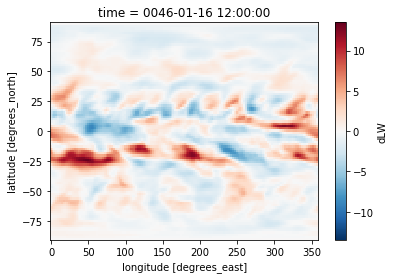

In [17]:
# Test plot
test = xr.open_dataset('nc_from_xarray/dLW_wv_og_'+model+'.nc')
test['dLW'].isel(time=0).plot()


In [ ]:
#Regrid to climatology grid in: 

#Script: "regrid_kernel_results_wv.py"


In [18]:
#Do the same for surface temperature (simpler--can use stuff that's already on climatology grid)

#Do this before I forget how to do it and it becomes harder

#Remember, this is already on climatology grid, so use kernel version that is also there. 

#But don't I have to regrid the surface temperature data to the climatology grid? 
#Already did this for APRP.

In [30]:
dLW_ts_dict = dict()
ds_clim = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl')    
kernel_ts = xr.open_dataset('../aquakernels_Feldl/aquakernels/lw_ts_rg.nc')

#print(kernel_ts)

for model in models_12:
    print(model)
    
    ds_mon_ts = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_'+model+'.nc')
    numMonths = len(ds_mon_ts.time)
    
    #Preallocate something to store the output after multiplication 
    dLW_ts_raw = np.zeros([numMonths, len(ds_mon_ts.lat), len(ds_mon_ts.lon)]) 

    #Loop through the months
    for i in np.arange(numMonths):
        if i % 20 == 0:
            print('month '+str(i))
            
        #Subsets for month, etc.
        ts_clim_i = ds_clim.sel(model=model).isel(time=i%12)['ts']
        ts_mon_i = ds_mon_ts.isel(time=i)['ts']
        kernel_i = kernel_ts.isel(time=i%12)['__xarray_dataarray_variable__']

        #Calculate temperature difference
        dT_i = ts_mon_i - ts_clim_i
                
        #Multiply by kernel
        dLW_ts_raw[i,:,:] = dT_i*kernel_i
        
    #Create XArray DataArray with the result
    dLW_ts_dict[model] = xr.DataArray(dLW_ts_raw, coords=[ds_mon_ts.time, ds_clim.lat, ds_clim.lon],  
                                      dims=['time', 'lat', 'lon'], name='dLW')
    
    

AM2
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
CAM3
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
CAM4
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
CNRM-AM6-DIA-v2
month 0
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
ECHAM-6.1
month 0
month 20
month 4

In [34]:
#Concatenate a single Dataset and save to NetCDF file
#No, can't do that--mismatched times. 
#import pandas as pd
#dLW_ts = xr.concat(dLW_ts_dict.values(), pd.Index(models_12))

#Save individual model results to NetCDF files: (use rg tag because already on climatology grid)
for model in models_12:
    dLW_ts_dict[model].to_netcdf('nc_from_xarray/dLW_ts_rg_'+model+'.nc')

In [43]:
#Check whether there are actually zero values for CNRM

ds_mon_wv = xr.open_dataset(glob.glob('../nc_esgf/Amon/hus_Amon_'+
                                      model_filenames['CNRM-AM6-DIA-v2']+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
ds_mon_wv = ds_mon_wv.reindex(plev=ds_mon_wv.plev[::-1]) #Flip pressure levels to match the order for the other two
testhus = ds_mon_wv['hus'].data
print(np.min(testhus))

0.0


In [45]:
#OK, so there are indeed zero values. 
#Try all models:

print('Minimum values of hus for each model in monthly output')
for model in models_12:
    ds_mon_wv = xr.open_dataset(glob.glob('../nc_esgf/Amon/hus_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_wv = ds_mon_wv.reindex(plev=ds_mon_wv.plev[::-1]) #Flip pressure levels to match the order for the other two
    testhus = ds_mon_wv['hus'].data
    print(model)
    print(np.min(testhus))

Minimum values of hus for each model in monthly output
AM2
4.4194218e-07
CAM3
3.0049796e-07
CAM4
8.368603e-08
CNRM-AM6-DIA-v2
0.0
ECHAM-6.1
2.7016455e-07
ECHAM-6.3
3.3281304e-07
IPSL-CM5A
nan


/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


MIROC5
nan
MPAS
6.928649e-07
MetUM-GA6-CTL
0.0
MetUM-GA6-ENT
0.0
NorESM2
1.6149779e-09


In [46]:
#OK, so CNRM has 0; MetUM models have 0; IPSL and MIROC have nans
#I think those might just be at edges. Try again with smaller subset
print(np.shape(testhus))

(492, 17, 96, 144)


In [51]:

print('Minimum values of hus for each model in monthly output')
for model in models_12:
    ds_mon_wv = xr.open_dataset(glob.glob('../nc_esgf/Amon/hus_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_wv = ds_mon_wv.reindex(plev=ds_mon_wv.plev[::-1]) #Flip pressure levels to match the order for the other two
    testhus = ds_mon_wv['hus'].data[:,:-1,:,:]
    print(model)
    print(np.min(testhus))
#OK, confirmed only CNRM has zero or nan value of hus outside the lowest pressure level, which gets dropped. 
#(even NP/SP not an issue)

Minimum values of hus for each model in monthly output
AM2
4.4194218e-07
CAM3
3.0049796e-07
CAM4
8.368603e-08
CNRM-AM6-DIA-v2
0.0
ECHAM-6.1
2.7016455e-07
ECHAM-6.3
3.3281304e-07
IPSL-CM5A
4.0350027e-08
MIROC5
4.2618314e-07
MPAS
6.928649e-07
MetUM-GA6-CTL
9.3099055e-07
MetUM-GA6-ENT
9.507071e-07
NorESM2
1.6149779e-09


In [1]:

#####   PLANCK AND LAPSE RATE FEEDBACKS   #####


In [2]:
#Lapse rate feedback in particular is important. 
#Redo the temperature kernel multiplication where multiplying by just the surface temperature change (Planck) 
#or the atmosphere minus surface temperature change (Lapse rate)

In [9]:
#What was the overall structure for this? 

#-Run the first few cells above up to calculating pressure level differences
#-Run the really big cell, "dLW_ta_dict" defined there (copy here and modify)
#-Save kernel results for individual models to netCDF files
#-Regrid from model grids to climatology grid in separate script ("regrid_kernel_results_ta.py")
#-Test loading the regidded files

In [30]:
#Test loading NetCDF file from "nc_ts_non_regridded" (necessary to subtract surface warming from atmospheric warming for lapse rate)
test = xr.open_dataset('../nc_ts_non_regridded/ts_clim_og_CAM3.nc')

In [31]:
print(test)

<xarray.Dataset>
Dimensions:  (exp: 4, lat: 64, lon: 128, time: 12)
Coordinates:
  * exp      (exp) object 'Aqua4xCO2' 'AquaControl' 'Land4xCO2' 'LandControl'
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2006-12-01
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 -180.0 -177.2 -174.4 -171.6 ... 171.6 174.4 177.2
Data variables:
    ts       (exp, time, lat, lon) float32 ...


In [1]:
### Lapse Rate Feedback ###

In [36]:
#Apply the temperature kernels in a loop over models and months;
#Vertically integrate, then regrid to the common climatology grid.

dLW_lr_dict = dict()
for model in models_12:
    print('Kernel multiplication (lapse rate) for model: ' + model)
    
    #Load the monthly and climatological temperatures and the kernel
    ds_clim_ta = xr.open_dataset('../nc_plev_non_regridded/master_plev_og_'+model+'.nc').sel(exp='AquaControl')
    ds_clim_ts = xr.open_dataset('../nc_ts_non_regridded/ts_clim_og_'+model+'.nc').sel(exp='AquaControl')    
    kernel_ta = xr.open_dataset('../aquakernels_Feldl/aquakernels/regridded_model_grids/lw_t_rg_'+model+'.nc')
    ds_mon_ta = xr.open_dataset(glob.glob('../nc_esgf/Amon/ta_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    ds_mon_ta = ds_mon_ta.reindex(plev=ds_mon_ta.plev[::-1]) #Flip pressure levels to match the order for the other two
    ds_mon_ts = xr.open_dataset(glob.glob('../nc_esgf/Amon/ts_Amon_'+
                                          model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
    numMonths = len(ds_mon_ta.time)
    
    #Preallocate something to store the output after multiplication and vertical integration for each month
    dLW_lr_raw = np.zeros([numMonths, len(ds_mon_ta.lat), len(ds_mon_ta.lon)]) 
    
    #Loop through the months
    for i in np.arange(numMonths):
        if i % 20 == 0:
            print('month '+str(i))
        
        #Extract climatological and monthly temperatures
        ds_clim_i = ds_clim_ta.isel(time=i%12)['ta']
        ds_mon_ta_i = ds_mon_ta.isel(time=i)['ta']
        ds_mon_ta_i_raw = ds_mon_ta_i.data
        
        ts_clim_i = ds_clim_ts.isel(time=i%12)['ts']
        ts_mon_i = ds_mon_ts.isel(time=i)['ts']
        ts_mon_i_raw = ts_mon_i.data
        
        #Interpolate from grid box boundaries to centers for the MetUM models
        #Use a temporary raw array, then reassign coords at the end
        if model in ['MetUM-GA6-CTL', 'MetUM-GA6-ENT']:
            temp_raw = ds_clim_i.data
            edge = temp_raw[:,:,0]
            temp_raw_1 = np.concatenate((temp_raw, edge[:,:,None]), axis=2) #duplicate edge lons
            temp_raw_2 = (temp_raw_1[:,:,:-1]+temp_raw_1[:,:,1:])/2. #midpoint along longitudes
            temp_raw_3 = (temp_raw_2[:,:-1,:]+temp_raw_2[:,1:,:])/2. #midpoint along latitudes
            
            #Reconstruct the XArray object. 
            #Dimensions of this variable don't actually matter from this point, except for dropping bottom plev
            ds_clim_i = xr.DataArray(temp_raw_3, {'plev': ds_mon_ta_i.plev, 'lat': ds_mon_ta_i.lat, 'lon': ds_mon_ta_i.lon},  
                                      dims=['plev', 'lat', 'lon'])
        
        #Drop bottom layer when multiplying kernel by temperature differece 
        #(since some models are missing data in the bottom layer sometimes)
        kernel_i = kernel_ta.isel(plev=np.arange(len(plev_widths)), time=i%12)
        kernel_raw = kernel_i['__xarray_dataarray_variable__'].data
        
        #Calculate the atmospheric and surface temperature change and subtract them
        
        #print(np.shape(ds_mon_ta_i_raw))
        #print(np.shape(ds_clim_i))
        if i == 0:
            print(np.shape(ts_mon_i))
            print(np.shape(ts_clim_i))
        
        #print(ds_mon_ta_i_raw)
        #print(ds_clim_i)
        
#         print('Calculating dTs_i = ts_mon_i - ts_clim_i')
#         print('ts_mon_i:')
#         print(ts_mon_i)
#         print(' ')
#         print('ts_clim_i:')
#         print(ts_clim_i)
#         print(' ')
        
        dT_i = ds_mon_ta_i_raw - ds_clim_i
        #print(dT_i)
        #print(' ')
        
        
        dTs_i = ts_mon_i_raw - ts_clim_i
#         print('dTs_i:')
#         print(dTs_i)
#         print(' ')

        if i == 0:
            print(dT_i)
            print(dTs_i)
        
        #Problem: different values of lat-lon (precision and 180 vs. 360) despite same grid so 
        #need to make one "raw". 
        #So need to 
        
        #print(np.shape(dT_i))
        #print(np.shape(dTs_i))
        
        dLR_i = dT_i - dTs_i.data
        if i == 0:
            print('dLR_i (first time step)')
            print(dLR_i)
        
        #print(np.shape(dLR_i))
        
        #Oh, boy... the atmospheric temperature is on the model grid while the surface temperature is on the climatology grid. 
        #How to fix this?
        #Have I regridded surface temperature to the model grids before? 
        #Might be easier to just download the surface temperature changes from ESGF
        #(Or maybe it can be gotten from the Lamont data library, like I did with CMIP5)
        #I have those downloaded already, as it turns out
        #Shouldn't need to regrid/modify the surface temperature stuff
        #(Except maybe time changes?)
        #OK, got the monthly surface temperature output--but still need the climatological surface temperatures on the model grids. 
        #This is what the script "MakeNetCDF_noregrid" was for. 
        
        #This is where I previously multiplied by the chahnge in the atmospheric temperature
        #--instead need to multiply by the atmospheric minus surface temperature change
        taTimesKernel_i = dLR_i.isel(plev=np.arange(len(plev_widths)))*kernel_raw
        
        #Vertically integrate (divide by 10000 because kernel was in W/m^2/100 hPa)
        dLW_lr_raw[i,:,:] = (taTimesKernel_i*plev_widths[:, None, None]/10000.0).sum(dim='plev')
        
    #Create XArray DataArray with the result
    dLW_lr_dict[model] = xr.DataArray(dLW_lr_raw, {'time': ds_mon_ta.time, 'lat': ds_mon_ta.lat, 'lon': ds_mon_ta.lon},  
                                      dims=['time', 'lat', 'lon'], name='dLW')
    
    
#Why did this work for 1st model but not the second? 
#2nd has nans in the dT_i
#Seems like subtracting 2 XArray objects with differnet dimensions and names doesn't always work. 
#Would it be better to duplicate the surface temperature 17 times first, and then subtract?
#Try just "raw" first
    

Kernel multiplication (lapse rate) for model: AM2
month 0
(90, 144)
(90, 144)
<xarray.DataArray 'ta' (plev: 17, lat: 90, lon: 144)>
array([[[-9.587875, -9.587875, ..., -9.587875, -9.587875],
        [-9.513443, -9.512558, ..., -9.51535 , -9.514404],
        ...,
        [-3.819977, -3.815521, ..., -3.828247, -3.824203],
        [-3.761368, -3.761368, ..., -3.761368, -3.761368]],

       [[-5.257584, -5.257584, ..., -5.257584, -5.257584],
        [-5.233643, -5.232788, ..., -5.235214, -5.234436],
        ...,
        [-2.681259, -2.674316, ..., -2.694977, -2.68811 ],
        [-2.686874, -2.686874, ..., -2.686874, -2.686874]],

       ...,

       [[ 1.381195,  1.381195, ...,  1.381195,  1.381195],
        [ 1.31543 ,  1.350281, ...,  1.232971,  1.26767 ],
        ...,
        [-0.033386, -0.01709 , ..., -0.036194, -0.036682],
        [-0.07663 , -0.07663 , ..., -0.07663 , -0.07663 ]],

       [[ 1.122253,  1.122253, ...,  1.122253,  1.122253],
        [ 0.832245,  0.845612, ...,  0.8129

In [37]:
#Save kernel results for individual models to netCDF files
for model in models_12:
    dLW_lr_dict[model].to_netcdf('nc_from_xarray/dLW_lr_og_'+model+'.nc')
    

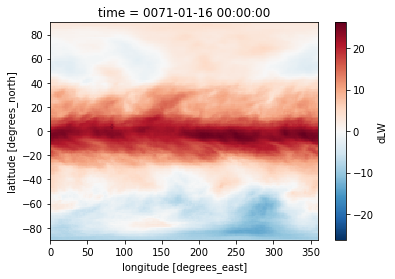

In [45]:
#Test plot
dLW_lr_dict['MetUM-GA6-CTL'].isel(time=300).plot()

#Does this make sense?
#Yes, opposite sign at low/high latitudes. (Assuming sign is right, looks like reduction in OLR at high lats)

In [42]:
#Now, need to regrid the changes in LW radiation to the climatology grid.

#Script: "regrid_kernel_results_lr.py"
#Done? Yes

AM2
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0046-01-16 00:00:00 ... 0085-12-16 00:00:00
Data variables:
    dLW      (time, lat, lon) float64 ...
CAM3
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
Data variables:
    dLW      (time, lat, lon) float64 ...
CAM4
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 00

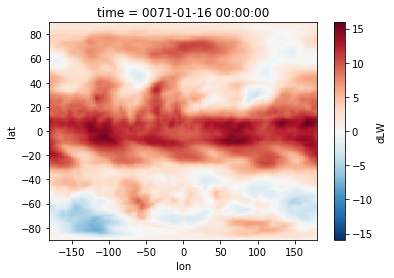

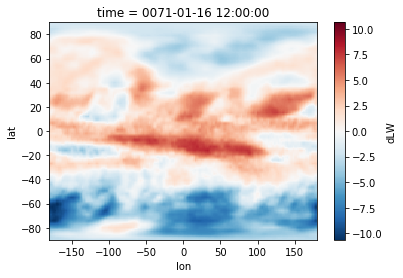

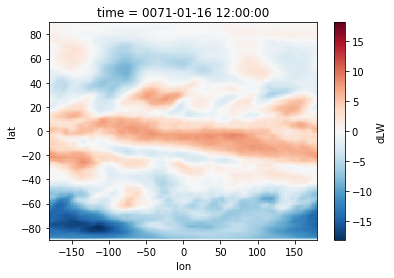

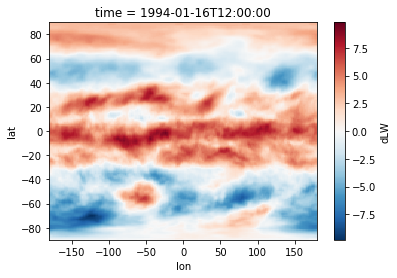

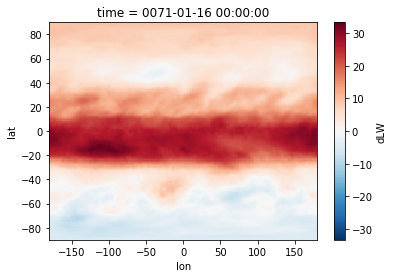

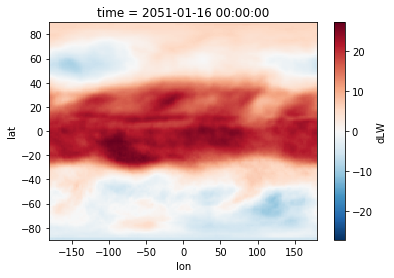

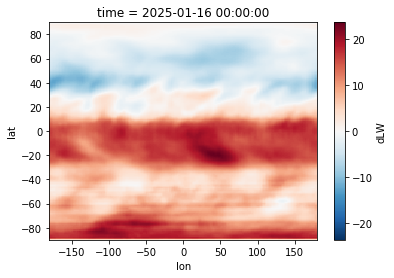

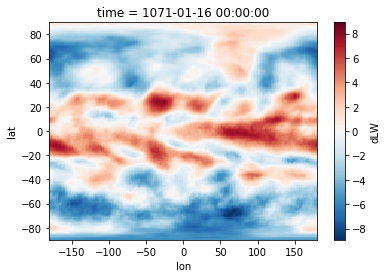

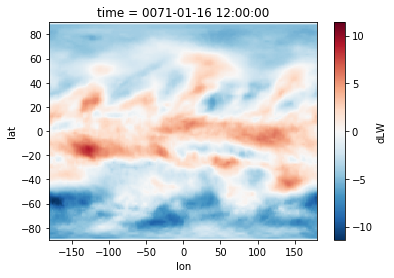

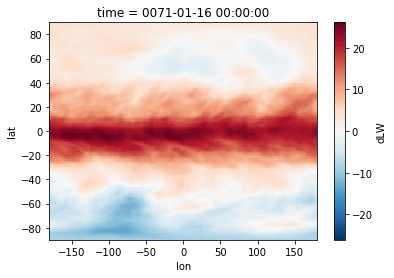

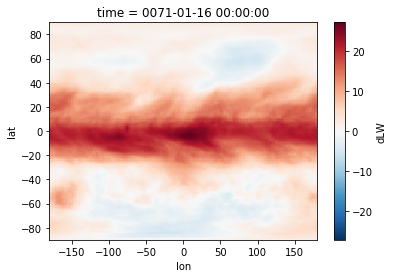

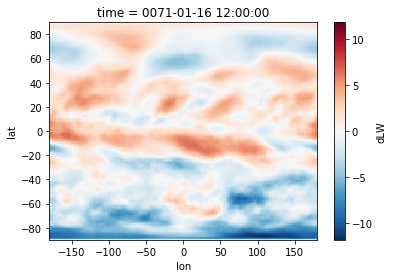

In [44]:
#Test loading the regridded datasets and plotting

for model in models_12:
    test = xr.open_dataset('nc_from_xarray/dLW_lr_rg_'+model+'.nc')
    print(model)
    print(test)
    plt.figure()
    test['dLW'].isel(time=300).plot()

In [46]:
#OK, this seems to be done, what next? 
#Chain of scripts, written down at Lamont on paper:
#(also see Github page)

#GregoryIndividualFeedbacks, 
#then EBM_Gregory_run_noG, 
#and EBM_LocalRemote_Gregory_run_noG,
#and EBM_noQ_run, 
#then finally the plotting scripts, redone to include this experiment.

#But do Planck feedback first. 

In [47]:
### Planck Feedback ###

In [48]:
#This one should be simpler--just multiply surface temperature change by atmospheric kernel, 
#so can use climatology grid for everything?

In [71]:
#Apply the temperature kernels in a loop over models and months;
#Vertically integrate, then regrid to the common climatology grid.

dLW_pl_dict = dict()

#Load the climatological temperatures and the atmospheric temperature kernel 
#(regridded to climatology grid)
ds_clim_ts = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl')   
kernel_ta = xr.open_dataset('../aquakernels_Feldl/aquakernels/lw_ta_rg.nc')

for model in models_12:
    print('Kernel multiplication (Planck) for model: ' + model)
    
    #Load the monthly surface temperatures
    ds_mon_ts = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_'+model+'.nc')
    numMonths = len(ds_mon_ts.time)
    ds_clim_ts_model = ds_clim_ts.sel(model=model)
    
    
    #Preallocate something to store the output after multiplication and vertical integration for each month
    dLW_pl_raw = np.zeros([numMonths, len(ds_clim_ts.lat), len(ds_clim_ts.lon)]) 
    
    #Loop through the months
    for i in np.arange(numMonths):
        if i % 20 == 0:
            print('month '+str(i))
        
        #Extract climatological and monthly temperatures
        ts_clim_i = ds_clim_ts_model.isel(time=i%12)['ts']
        ts_mon_i = ds_mon_ts.isel(time=i)['ts']
        ts_mon_i_raw = ts_mon_i.data
        
        #Drop bottom layer when multiplying kernel by temperature differece 
        #(since some models are missing data in the bottom layer sometimes)
        kernel_i = kernel_ta.isel(plev=np.arange(len(plev_widths)), time=i%12)
        #kernel_raw = kernel_i['__xarray_dataarray_variable__'].data
        
        #Calculate the surface temperature change and subtract them
        
        dTs_i = ts_mon_i_raw - ts_clim_i
        
#         if i == 0:
#             print(np.shape(kernel_i['__xarray_dataarray_variable__'].data))
#             print(ts_mon_i)
#             print(kernel_i)
#             print(kernel_i['plev'])
#             print(dTs_i)
#             print(len(kernel_i['plev']))
#             #print(kernel_raw)
            #print(np.shape(kernel_raw))
            #print(np.shape(kernel_i))
        
        #Multiply by kernel
        #Having trouble broadcasting the temperature change, need to manually extend/tile along 
        #the third dimension.
        dTs_i_tiled = np.tile(dTs_i.data, (len(kernel_i.plev), 1, 1))
        if i == 0:
            print(np.shape(dTs_i_tiled))
        tsTimesKernel_i = dTs_i_tiled*kernel_i['__xarray_dataarray_variable__']
        
        
        #Vertically integrate (divide by 10000 because kernel was in W/m^2/100 hPa)
        dLW_pl_raw[i,:,:] = (tsTimesKernel_i*plev_widths[:, None, None]/10000.0).sum(dim='plev')
        
    #Create XArray DataArray with the result
    dLW_pl_dict[model] = xr.DataArray(dLW_pl_raw, {'time': ds_mon_ts.time, 'lat': ds_clim_ts.lat, 'lon': ds_clim_ts.lon},  
                                      dims=['time', 'lat', 'lon'], name='dLW')
    

Kernel multiplication (Planck) for model: AM2
month 0
(16, 180, 180)
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (Planck) for model: CAM3
month 0
(16, 180, 180)
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (Planck) for model: CAM4
month 0
(16, 180, 180)
month 20
month 40
month 60
month 80
month 100
month 120
month 140
month 160
month 180
month 200
month 220
month 240
month 260
month 280
month 300
month 320
month 340
month 360
month 380
month 400
month 420
month 440
month 460
Kernel multiplication (Planck) for model: CNRM-AM6-DIA-v2
month 0
(16, 180, 180)
month 20
month 40
month 60
month

In [ ]:
#Save the Planck feedback results to NetCDF files,
#similar to the surface temperature kernel

In [73]:
#Save individual model results to NetCDF files: (use rg tag because already on climatology grid)
for model in models_12:
    dLW_pl_dict[model].to_netcdf('nc_from_xarray/dLW_pl_rg_'+model+'.nc')

AM2
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * time     (time) object 0046-01-16 00:00:00 ... 0085-12-16 00:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    dLW      (time, lat, lon) float64 ...
CAM3
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    dLW      (time, lat, lon) float64 ...
CAM4
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 480)
Coordinates:
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.0 -

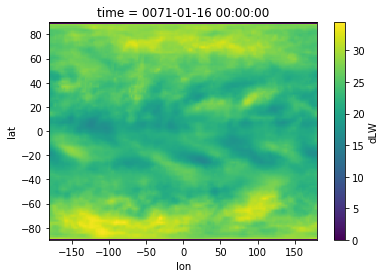

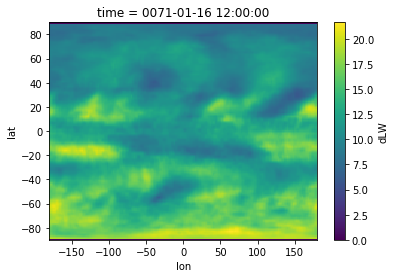

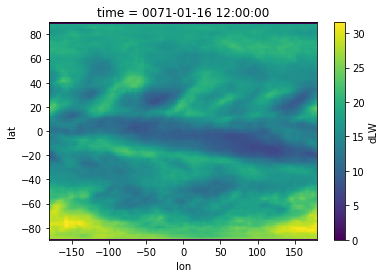

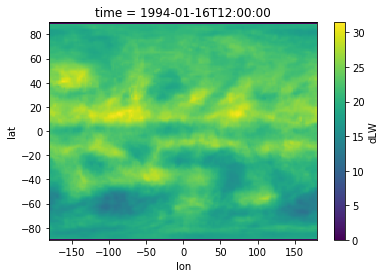

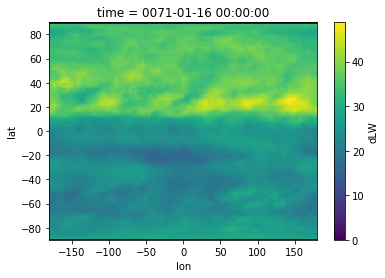

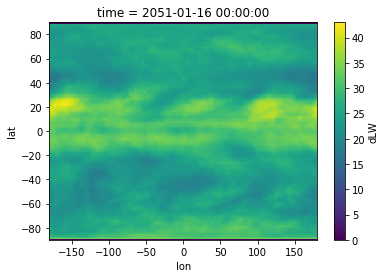

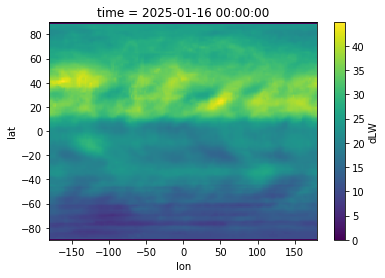

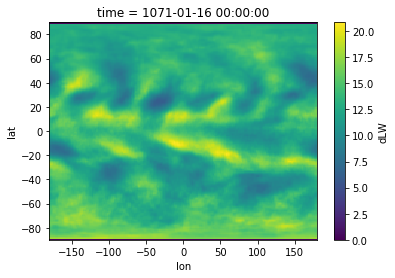

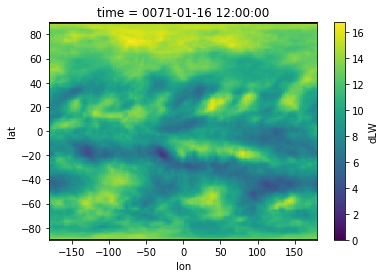

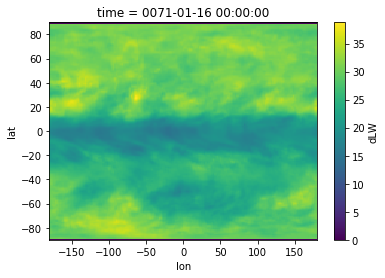

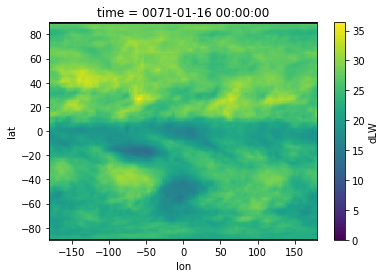

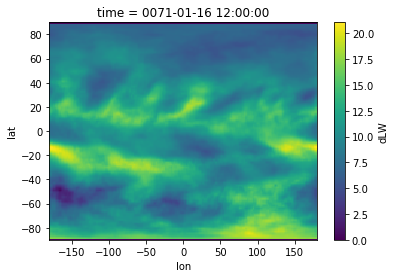

In [89]:
#Plot what the Planck feedback looks like, similar to lapse rate feedback above

for model in models_12:
    test = xr.open_dataset('nc_from_xarray/dLW_pl_rg_'+model+'.nc')
    print(model)
    print(test)
    plt.figure()
    test['dLW'].isel(time=300).plot()
    
#Generally increases in OLR, makes sense

In [72]:
#Sanity check: do Planck and Lapse Rate feedback results add up 
#to the total temperature kernel results?

In [80]:
#Results: it's pretty similar but there are some differences on the order of 1 W/m^2.
#(Also watch out for edge effects--treatment of nans?)
#Differences are bigger before zonal averaging, that could be a clue? 
#This stuff should add up to 0, really--kernel multiplication should be linear. 
#This amounts to taking, at each lat-lon-height grid point: 
#[(atmos. warming) - (surface warming) - (atmos. warming - surface warming)]*atmos. kernel
#Which should be zero. 

#Maybe could be tiny errors from multiplying by different regriddings of kernels?
#But more likely seems like there might be a "180 degree" offset error in the kernel in 
#one or more of these multiplications? 

#So plot differences in the 2 kernels? 

#"Bottom layer" issue as well?

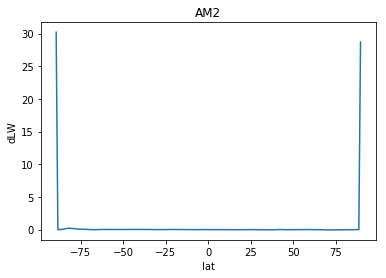

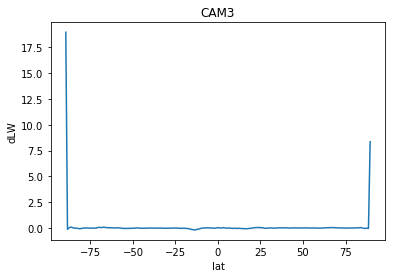

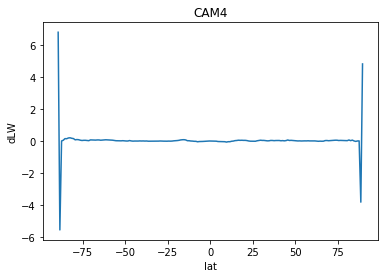

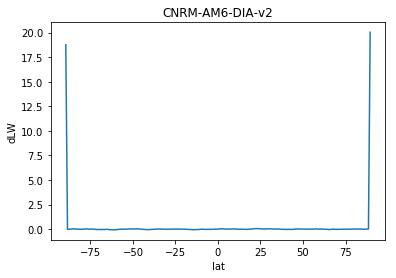

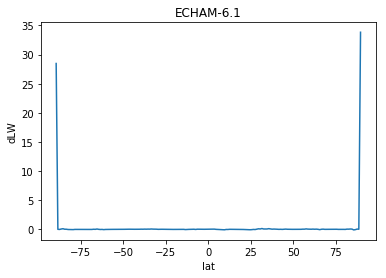

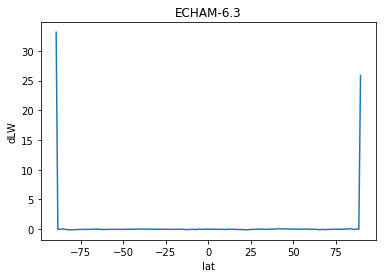

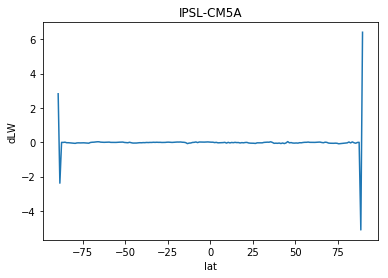

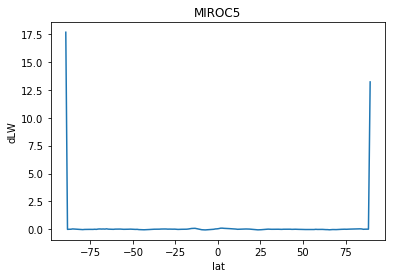

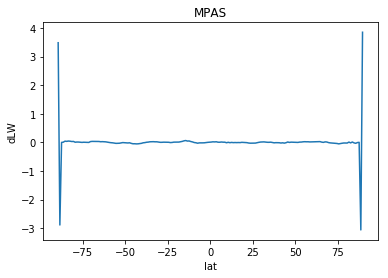

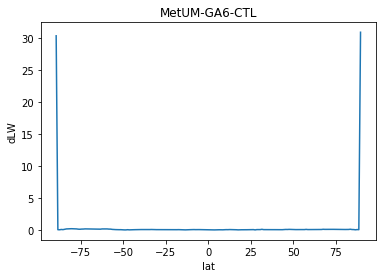

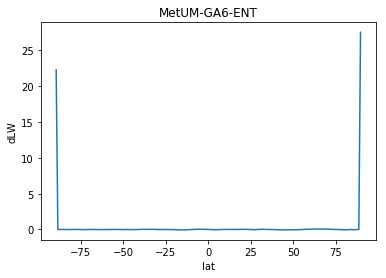

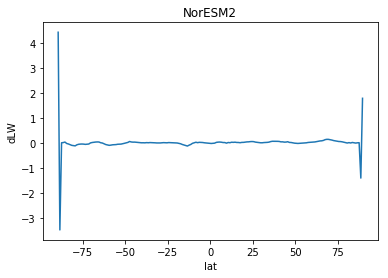

In [79]:
#Load the 3 "dLW" files, take differences, and plot

for model in models_12:
#for model in ['AM2']:   
    dLW_ta_local = xr.open_dataarray('nc_from_xarray/dLW_ta_rg_'+model+'.nc')
    dLW_lr_local = xr.open_dataarray('nc_from_xarray/dLW_lr_rg_'+model+'.nc')
    dLW_pl_local = xr.open_dataarray('nc_from_xarray/dLW_pl_rg_'+model+'.nc')
    
    resid = dLW_ta_local-dLW_lr_local-dLW_pl_local
    
    plt.figure()
    #print(resid)
    #resid.isel(time=300).plot()
    resid.mean(dim='lon').isel(time=300).plot()
    plt.title(model)

In [83]:
#Plot the kernels in 2 different regriddings to make sure it still looks right
kernel_ta_clim = xr.open_dataset('../aquakernels_Feldl/aquakernels/lw_ta_rg.nc')
model = 'CAM4'
kernel_ta_CAM4 = xr.open_dataset('../aquakernels_Feldl/aquakernels/regridded_model_grids/lw_t_rg_'+model+'.nc')


In [86]:
print(kernel_ta_clim)
print(kernel_ta_CAM4)

<xarray.Dataset>
Dimensions:                        (lat: 180, lon: 180, plev: 17, time: 12)
Coordinates:
  * time                           (time) datetime64[ns] 2006-01-01 ... 2006-12-01
  * lat                            (lat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                            (lon) float64 -179.0 -177.0 ... 177.0 179.0
  * plev                           (plev) int64 1000 2000 3000 ... 92500 100000
Data variables:
    __xarray_dataarray_variable__  (time, plev, lat, lon) float64 ...
<xarray.Dataset>
Dimensions:                        (lat: 96, lon: 144, plev: 17, time: 12)
Coordinates:
  * time                           (time) datetime64[ns] 2006-01-01 ... 2006-12-01
  * lat                            (lat) float64 -90.0 -88.11 ... 88.11 90.0
  * lon                            (lon) float64 0.0 2.5 5.0 ... 355.0 357.5
  * plev                           (plev) int64 1000 2000 3000 ... 92500 100000
Data variables:
    __xarray_dataarray_variable__  (time, plev,

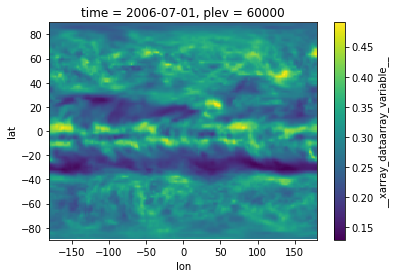

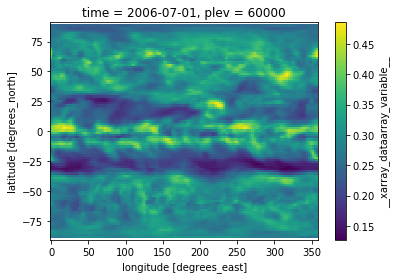

In [88]:
plt.figure()
kernel_ta_clim['__xarray_dataarray_variable__'].isel(plev=12,time=6).plot()
plt.figure()
kernel_ta_CAM4['__xarray_dataarray_variable__'].isel(plev=12,time=6).plot()

In [ ]:
#OK, these at least look the same--I am multiplying by the same kernels

#What about the grid the surface temperature is on?

#For lapse rate feedback:
#ds_clim_ts = xr.open_dataset('../nc_ts_non_regridded/ts_clim_og_'+model+'.nc').sel(exp='AquaControl')    
#ds_mon_ts = xr.open_dataset(glob.glob('../nc_esgf/Amon/ts_Amon_'+model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])

#For Planck feddback: 
#ds_clim_ts = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl')   
#ds_mon_ts = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_'+model+'.nc')


In [93]:
#Plot these above things for an example model
model = 'CAM4'

#Climatological--load
ts_clim_test_lr = xr.open_dataset('../nc_ts_non_regridded/ts_clim_og_'+model+'.nc').sel(exp='AquaControl')    
ts_clim_test_pl = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl', model=model)   

#Monthly--load
ts_mon_test_lr = xr.open_dataset(glob.glob('../nc_esgf/Amon/ts_Amon_'+model_filenames[model]+'_aqua4xCO2TRACMIP_r1i1p1_*')[0])
ts_mon_test_pl = xr.open_dataset('nc_from_xarray/monthlyForGregAPRP_a4_rg_'+model+'.nc')

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 12)
Coordinates:
    exp      <U11 'AquaControl'
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2006-12-01
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Data variables:
    ts       (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:  (lat: 180, lon: 180, time: 12)
Coordinates:
    exp      <U11 'AquaControl'
    model    <U4 'CAM4'
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2006-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    clt      (time, lat, lon) float64 ...
    FLDS     (time, lat, lon) float64 ...
    FLDSC    (time, lat, lon) float64 ...
    FLNS     (time, lat, lon) float64 ...
    FLNSC    (time, lat, lon) float64 ...
    FLNT     (time, l

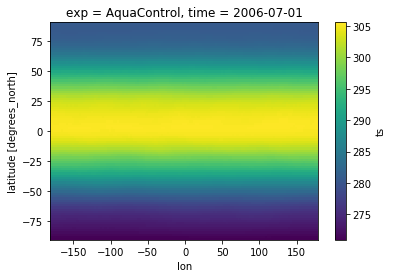

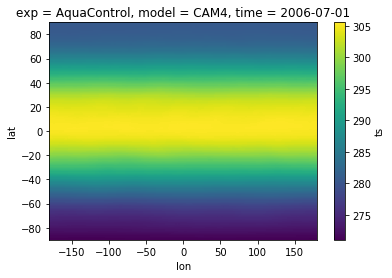

In [99]:
#Climatology--print and plots
print(ts_clim_test_lr)
print(ts_clim_test_pl)
plt.figure()
ts_clim_test_lr['ts'].isel(time=6).plot()
plt.figure()
ts_clim_test_pl['ts'].isel(time=6).plot()

#This seems the same--so zonally uniform longitudes couldn't be causing problems anyway

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 480)
Coordinates:
  * time       (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    ts         (time, lat, lon) float32 ...
Attributes:
    institution:            University at Albany (State University of New York)
    institute_id:           UAlbany
    experiment_id:          aqua4xCO2TRACMIP
    source:                 1.98 lat X 2.58 lon, finite volume (nominally 2.0...
    model_id:               CAM4
    forcing:                CO2
    parent_experiment_id:   aquaControlTRACMIP
    parent_experiment_rip:  r1i1p1
    branch_time:            0.0
    contact:                brose@albany

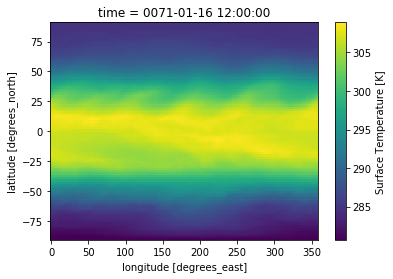

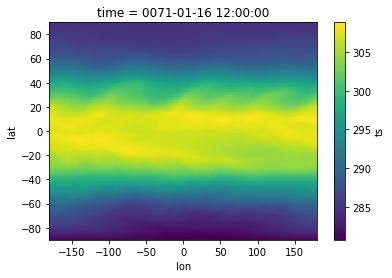

In [100]:
#Monthly--print and plots
print(ts_mon_test_lr)
print(ts_mon_test_pl)

plt.figure()
ts_mon_test_lr['ts'].isel(time=300).plot()
plt.figure()
ts_mon_test_pl['ts'].isel(time=300).plot()

In [ ]:
#OK, indeed 180 degree offset for the Planck feedback is the problem. 
#How to fix this--and is it even worth it?
#Can just extract the Planck radiation change by subtrating lapse rate from the total. 

#So move on to looking at what the lapse rate feedback actually does. Work in script "GregoryIndividualFeedbacks". 